In [ ]:
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [ ]:
!pip install keras

!pip install kerassurgeon

! pip install tfkerassurgeon
#Selection of version of tensorflow in colab
%tensorflow_version 1.x

     |████████████████████████████████| 10.5MB 10.5MB/s 
     |████████████████████████████████| 276kB 53.3MB/s 
     |████████████████████████████████| 2.2MB 68.7MB/s 
ERROR: google-colab 1.0.0 has requirement pandas~=1.0.0; python_version >= "3.0", but you'll have pandas 1.1.2 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: pandas 1.0.5
    Uninstalling pandas-1.0.5:
      Successfully uninstalled pandas-1.0.5
  Found existing installation: pluggy 0.7.1
    Uninstalling pluggy-0.7.1:
      Successfully uninstalled pluggy-0.7.1
  Found existing installation: pytest 3.6.4
    Uninstalling pytest-3.6.4:
      Successfully uninstalled pytest-3.6.4
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow

  Created wheel for tfkerassurgeon: filename=tfkerassurgeon-0.2.1-cp36-none-any.whl size=22026 sha256=5056204adcd2dfeeea03d0c73670f61494e02a3b43dc514f3eabead39ceaec99
  Stored in directory: /root/.cache/pip/wheels/33/41/28/daca963a6834fecf8cd9a3b207288ba325fdf012a7ebd95715
Successfully built tfkerassurgeon
TensorFlow 1.x selected.


In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Thu Aug 29 10:06:29 2019

@author: gourgue
"""

import keras
#%%
from keras.applications import DenseNet201
from keras              import backend, layers, models, utils
from keras.layers       import Input,Dense, Activation, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers       import Dropout
from keras.models       import Model, load_model
from keras.optimizers   import Adam
from keras.callbacks    import ModelCheckpoint, CSVLogger
#from keras.utils        import np_utils, plot_model

#from fonction_compteur import ouvrir

import numpy as np

import time, datetime, os, random, sys

# import kerassurgeon
# from kerassurgeon.operations import delete_layer, insert_layer, delete_channels
# from kerassurgeon import Surgeon

sys.path.append('/content/drive/My Drive/Stage/code_test_nicolas/')

import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.utils   import class_weight
from my_classes import DataGenerator, get_labels, DataGeneratorTopHat,DataGeneratorCentral
from function_model import create_model, SaveModel, LoadModel
from function_verification import creation_folder
from function_data import save_data
from function_affiche import  plot_time

from skimage.io import imread, imsave

import scipy.io.matlab as mio

matplotlib.rcParams.update({'font.size': 16})


Using TensorFlow backend.


In [ ]:

#%% parameters non reglable
debut=time.time()
classe_name=['saines','infecté']
datasets=['basic','different','ponderate','combo']
pre_trains=['imagenet',None]
colors=['R','G','B','RGB']
champs=['RAW_0','BF','DF',"RAW"]
patients=['CAT01/','KPJ0/','DA/','LE/']
nb_led=[1,7,19,35,49]
BF3=list(range(0+1,nb_led[0]+1))+list(range(nb_led[0]+1,nb_led[1]+1))
DF8=list(range(nb_led[2], nb_led[3]+1))
BF11=BF3+DF8
ALL=list(range(0,35))
LEDS=[False,BF3,DF8,BF11,ALL,'multi_led']
disks=["HDD","SSD"]
archis=['resnet_101','densenet_201','resnet_152']

#%% parametres réglable
#dimension d'entrée
input_shape=(84,84,3)
#pas d'apprentissage
lr=0.00001
#momentumm
momentum=0.9
#nombre d'entrainement
nb_train=50
#taille du batch
batch_size=64
#séparation train val et test
nb_split=0.8
#mélange de train et val
shuffle=True
#séparation train et val
nb_val=0.8
#nombre de classe
num_cla=2
#choix de la répartition
dataset=datasets[3]
#choix de pré entrainement
pre_train=pre_trains[0]
#couleur
color=colors[1]
#tophat
tophat = False
#champs
champ=champs[0]
# tableau modèle ensemble/entrainement images
LOAD = [False, False]
SAVE = [True , True, False]
#date load
date_load='data/'
LED=LEDS[0]
disk=disks[1]
archi=archis[2]

#%%
#tophat
if tophat is True:
    pre_train=pre_trains[1]
    input_shape=(input_shape[0], input_shape[1],2)
    if color ==colors[3]:
        color=colors[1]
        

#save folder
Folder_save =  "/content/drive/My Drive/Stage/classification/save"
#date =time.localtime()
#date_str = str(date[0])+'-'+str(date[1])+'-'+str(date[2])
Folder_load = "/content/drive/My Drive/Stage/classification/" +date_load
#Folder_save = Folder_save +date_str+'/'
Folder_save=creation_folder(Folder_save)
    
if LED is False:
    input_shape=(84,84,3)
elif type(LED) is str:
    pre_train=pre_trains[1]
else:
    input_shape = (84,84,len(LED))
    pre_train = pre_trains[1]
    
#model_convolution resnet_152 300 epochs combo dataset imagenet G RAW_0    
#name
if pre_train is None:
    name=archi+' '+str(nb_train)+' epochs '+dataset+' dataset ' + ' imagenet '+color+' '+champ
else:
    name=archi+' '+str(nb_train)+' epochs '+dataset+' dataset '+pre_train+' '+color+' '+champ
#%% model

if LOAD[0]:
#use LoadModel à la place
    try :
        model_01=LoadModel(Folder_load+'modele/model_convolution'+name)
    except:
        epoch_max=0
        model_names=os.listdir(Folder_load+'checkpointer/')
        for model_name in model_names:
            epoch=model_name[model_name.find("epoch=")+6:model_name.find("-val")]
            if int(epoch)>epoch_max:
                epoch_max=int(epoch)
                model_name_max=model_name
        model_01=load_model(Folder_load+'checkpointer/'+model_name_max)
        print("model load with :",epoch_max)
            
else:
    model_01 = create_model(archi, input_shape, num_cla, pre_train=pre_train)
    
    #https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33

    model_01.name=name

#%%
#extract data
if LOAD[1]:
    partition = mio.loadmat(Folder_load+'ensemble/'+model_01.name+' partition.mat')
    for part in ["train","valid","test"]:
        lenght=len(partition[part])
        partition[part]=list(partition[part])
        for indice,image_name in enumerate(partition[part]):
            partition[part][indice]=image_name[:image_name.find(".")+4]
            if len(partition[part][indice])<10:
                print(image_name)
    weights  = partition["weights"]
    
else:
    if dataset !=datasets[2]:
        if disk=="HDD":
            travel_healthy="/content/drive/My Drive/Stage/led0/"
            travel_infected="/content/drive/My Drive/Stage/led0/"
        elif disk=='SSD':
            travel_healthy="/content/drive/My Drive/Stage/led0/"
            travel_infected="/content/drive/My Drive/Stage/led0/"
        
        #infected extract
        image_infected=[]
        #travel_input_KPJ0=travel_infected+patients[1]+'/'+color+'/'+champ+'/'+'infected/'
        travel_input_CAT01 = travel_infected+patients[0]
        #folders_KPJ0 = os.listdir(travel_input_KPJ0)
        folders_CAT01 = os.listdir(travel_input_CAT01)
        # for i in range(len(folders_KPJ0)):    
        #     folders_KPJ0[i] = travel_input_KPJ0+folders_KPJ0[i]
        for i in range(len(folders_CAT01)):    
            folders_CAT01[i] = travel_input_CAT01+folders_CAT01[i]
        folders = folders_CAT01#+folders_KPJ0
        random.shuffle(folders)
        
        for folder in folders:
            if '_tophat' in folder:
                pass
            else:
                files= os.listdir(folder)
                n = 0
                for file in files:
                    if 'infected' in file:
                          if 'aug_29' not in file:
                            if 'aug_28' not in file:
                              image_infected.append(folder+'/'+file)
                              n=n+1
                print(folder)
                print(n)
        print(image_infected)
        print(len(image_infected))
        nb_cells_infected=len(image_infected)
        #healthy extract
        nb_cells_healthy=nb_cells_infected
        image_healthy=[]
        #on prend toute les cellules de CAT01
        patient=patients[0]
        travel_input="/content/drive/My Drive/Stage/led0/"+patients[0]
        folders = os.listdir(travel_input)
        for folder in folders:
            if not '_tophat' in folder:
                files = os.listdir(travel_input+folder)
                for file in files:
                    if 'healthy' in file:
                        image_healthy.append(travel_input+folder+'/'+file)

        print(len(image_healthy))                   
        nb_cells_healthy_rest = nb_cells_healthy-len(image_healthy)
        nb_cells_healthy_part=int(nb_cells_healthy_rest/3)
        cells_choice=[]
        for patient in patients[1:]:
            cells_patient=[]
            travel_input="/content/drive/My Drive/Stage/led0/"+patients[0]
            folders = os.listdir(travel_input)
            for folder in folders:
                if '_tophat' in folder :
                    pass
                else:
                    files= os.listdir(travel_input+folder)
                    for file in files:
                        if 'healthy' in file:
                            cells_patient.append(travel_input+folder+'/'+file)
            cells_choice.append(cells_patient)
        
        # for cells_patient in cells_choice:
        #     if len(cells_patient)==0:
        #         pass
        #     else:
        #         cells=random.sample(cells_patient, nb_cells_healthy_part)
        #         image_healthy=image_healthy+cells
        
        #différente répartition
        if dataset == datasets[0]:
            image_total = image_healthy+image_infected
            random.shuffle(image_total)
            
            image_train=image_total[:int(len(image_total)*nb_split*nb_val)]
            image_val  =image_total[int(len(image_total)*nb_split*nb_val):int(len(image_total)*nb_split)]
            image_test =image_total[int(len(image_total)*nb_split):]
            
            del(image_total)
            
        elif dataset == datasets[1] or dataset ==datasets[3]:
            point_depart = random.randint(0,nb_cells_infected-1)
            
            if point_depart+len(image_infected)*nb_split*nb_val < len(image_infected) :
                #cas ou le point de départ est avant les 34 premier %
                image_train=image_infected[point_depart:point_depart+int(len(image_infected)*nb_split*nb_val)]
                
                if point_depart+len(image_infected)*nb_split< len(image_infected) :
                    #cas ou le point de départ est avant les 20 premier %
                    image_val=image_infected[point_depart+int(len(image_infected)*nb_split*nb_val):\
                                             point_depart+\
                                            int(len(image_infected)*nb_split)]
                    
                    if point_depart+len(image_infected)== len(image_infected):
                        #cas ou le point de départ est 0
                        image_test=image_infected[point_depart+int(len(image_infected)*nb_split):]
                        
                    else:
                        image_test = image_infected[point_depart+int(len(image_infected)*nb_split):]
                        nb_cell_case = len(image_test)
                        nb_cell_rest = int(len(image_infected)*(1-nb_split))
                        image_test = image_test + image_infected[:nb_cell_rest]
                    
                else:
                    image_val=image_infected[point_depart+int(len(image_infected)*nb_split*nb_val):]
                    nb_cell_case = len(image_val)
                    nb_cell_rest = int(len(image_infected)*(1-nb_split)*(1-nb_val))
                    image_val = image_val + image_infected[:nb_cell_rest]
                    
                    image_test = image_infected[nb_cell_rest:int(len(image_infected)*(1-nb_split))]
                
            else:
                #cas ou le point de départ est au dela des 34 premier %
                image_train=image_infected[point_depart:]
                nb_cell_case=len(image_train)
                nb_cell_rest=int(len(image_infected)*nb_split*nb_val-nb_cell_case)
                image_train=image_train+image_infected[:nb_cell_rest]
                
                image_val  =image_infected[nb_cell_rest:nb_cell_rest+int(len(image_infected)*(nb_split)*\
                                                                         (1-nb_val))]
                image_test =image_infected[nb_cell_rest+int(len(image_infected)*(nb_split)*(1-nb_val)):\
                                        nb_cell_rest+int(len(image_infected)*(nb_split)*(1-nb_val))+\
                                        int(len(image_infected)*(1-nb_split))]
            if dataset == datasets[1]:    
                image_train = image_train + image_healthy[:len(image_train)]
                image_val   = image_train + image_healthy[len(image_train):len(image_train)+len(image_val)]
                image_test  = image_test  + image_healthy[-len(image_test):]
                
                random.shuffle(image_train)
                random.shuffle(image_val)
                random.shuffle(image_test)
            
        weights=[1,1]
                
    if dataset==datasets[2] or dataset== datasets[3]:
        if disk=="HDD":
            travel="/content/drive/My Drive/Stage/led0/"
        elif disk=="SSD":
            travel="/content/drive/My Drive/Stage/led0/"
 
        if dataset == datasets[2]:
            #infected extract
            image_infected=[]
            for patient in patients[:2]:
                travel_input=travel+patient+'/'+color+'/'+champ+'/'
                folders = os.listdir(travel_input)
                for folder in folders:
                    if '_tophat' in folder:
                        pass
                    else:
                        files= os.listdir(travel_input+folder)
                        for file in files:
                            if 'infected' in file:
                                image_infected.append(travel_input+folder+'/'+file)
                                
            nb_cells_infected=len(image_infected)
        #healthy extract
        nb_cells_healthy=nb_cells_infected
        image_healthy=[]
        #on prend toute les cellules
        for patient in patients[:1]:
            cells_patient=[]
            travel_input="/content/drive/My Drive/Stage/led0/"+patient
            folders = os.listdir(travel_input)
            for folder in folders:
                if '_tophat' in folder:
                    pass
                else:
                    files= os.listdir(travel_input+folder)
                    for file in files:
                        if 'healthy' in file:
                            image_healthy.append(travel_input+folder+'/'+file)
    
        #constitution des ensembles train     
        if dataset == datasets[2] :           
            random.shuffle(image_infected)
        random.shuffle(image_healthy)
        image_train=image_infected[:int(len(image_infected)*nb_split*nb_val)]+\
                    image_healthy[:int(len(image_healthy)*nb_split*nb_val)]
        
        image_val=image_infected[int(len(image_infected)*nb_split*nb_val):int(len(image_infected)*nb_split)]+\
                  image_healthy[int(len(image_healthy)*nb_split*nb_val):int(len(image_healthy)*nb_split)]                
        
        image_test=image_infected[int(len(image_infected)*nb_split):]+image_healthy[int(len(image_healthy)*nb_split):]
        
        random.shuffle(image_train)
        random.shuffle(image_val)
        random.shuffle(image_test)
        
        
        Y_w=[]
        len_infec = 0 
        len_healt = 0 
        for image in image_infected+image_healthy:
            trav, image_name = os.path.split(image)
            if 'healthy' in image_name:
                len_healt = len_healt + 1
                Y_w.append(0)
            elif 'infected' in image_name:
                len_infec = len_infec + 1
                Y_w.append(1)
            else:
                print("problème label")
        Y_w = np.array(Y_w)
            
        weights = class_weight.compute_class_weight('balanced', np.unique(Y_w), Y_w)
        
        
        print(Y_w)
        print(len_healt)
        print(len_infec)
        print(weights)
        
    del(image_infected)
    del(image_healthy)
 
    #répartition des chemin en ensemble 
    
    partition={'train':[],'valid':[],'test':[]}
    partition['train'] = image_train
    partition['valid'] = image_val
    partition['test' ] = image_test
    partition['weights'] = weights
        
    del(image_train)
    del(image_val)
    del(image_test)

if SAVE[1]:
    save_data(Folder_save+'ensemble/'+model_01.name+' partition.mat', partition)
#    if not os.path.exists(Folder_save+'ensemble/'):
#        os.mkdir(Folder_save+'ensemble/')
#    mio.savemat(Folder_save+'ensemble/'+model_01.name+' partition.mat',partition)
#%%
#Generators 
if tophat:
    training_generator   = DataGeneratorTopHat(partition["train"], batch_size=batch_size, dim=input_shape[:2], 
                                       n_channels=input_shape[2], n_classes=num_cla, shuffle=shuffle)
    validation_generator = DataGeneratorTopHat(partition["valid"], batch_size=batch_size, dim=input_shape[:2], 
                                       n_channels=input_shape[2], n_classes=num_cla, shuffle=shuffle)
    testing_generator    = DataGeneratorTopHat(partition["test" ], batch_size=batch_size, dim=input_shape[:2], 
                                       n_channels=input_shape[2], n_classes=num_cla, shuffle=False)
    
else :    
    training_generator   = DataGeneratorCentral(partition["train"], batch_size=batch_size, dim=input_shape[:2], 
                                       n_channels=input_shape[2], n_classes=num_cla, shuffle=shuffle, LEDS=LED)
    validation_generator = DataGeneratorCentral(partition["valid"], batch_size=batch_size, dim=input_shape[:2], 
                                       n_channels=input_shape[2], n_classes=num_cla, shuffle=shuffle, LEDS=LED)
    testing_generator    = DataGeneratorCentral(partition["test" ], batch_size=batch_size, dim=input_shape[:2], 
                                       n_channels=input_shape[2], n_classes=num_cla, shuffle=False, LEDS=LED)

#%% train
opt= Adam(lr, momentum)
model_01.name="modelo"
model_01.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# model_01.summary()

#model_01.summary()

if LOAD[0]:
    history1=model_01.history
    if SAVE[1]: 
        if not os.path.exists(Folder_save+'checkpointer/'):
            os.mkdir(Folder_save+'checkpointer/')
        if not os.path.exists(Folder_save+'history/'):
            os.mkdir(Folder_save+'history/')            
        trainpath=Folder_save+'history/'+archi+' train.log'
        csv_logger = CSVLogger(trainpath)
        modelpath=Folder_save+'checkpointer/'+archi+'-epoch={epoch:03d}-val_acc={val_acc:.2f}.hdf5'
        checkpointer = ModelCheckpoint(filepath=modelpath, monitor="val_acc", verbose=1, 
                                       save_best_only=False, save_weights_only=False, period=10)
        history = model_01.fit_generator(generator=training_generator, validation_data=\
                                         validation_generator, epochs=nb_train, verbose=True,
                                         class_weight=weights,callbacks=[checkpointer,csv_logger])
    else:
        history = model_01.fit_generator(generator=training_generator, 
                                   validation_data=validation_generator, 
                                   epochs=nb_train, verbose=True,class_weight=weights)
        for key in history.history.keys():
            history.history[key]=history1[key]+history.history[key]
else:
    if SAVE[1]: 
        if not os.path.exists(Folder_save+'checkpointer/'):
            os.mkdir(Folder_save+'checkpointer/')
        if not os.path.exists(Folder_save+'history/'):
            os.mkdir(Folder_save+'history/')
            
        trainpath=Folder_save+'history/'+archi+' train.log'
        csv_logger = CSVLogger(trainpath)
        modelpath=Folder_save+'checkpointer/'+archi+' epoch={epoch:03d}-val_acc={val_accuracy:.2f}.hdf5'
        checkpointer = ModelCheckpoint(filepath=modelpath, monitor="val_accuracy", verbose=1, 
                                       save_best_only=False, save_weights_only=False, period=10)
        history = model_01.fit_generator(generator=training_generator, validation_data=\
                                         validation_generator, epochs=nb_train, verbose=True,
                                         class_weight=weights,callbacks=[checkpointer,csv_logger])
    
    else:
        history = model_01.fit_generator(generator=training_generator, validation_data=\
                                         validation_generator, epochs=nb_train, verbose=True,
                                         class_weight=weights)
        
##%% bidouyage
#from keras.callbacks import History
#import pandas as pd
#histoire=History()
#setattr(histoire, 'epoch', np.array(range(160)))
#histoiri=pd.read_csv(Folder_load+'history/resnet_101 train.log')
#keys=history.history.keys()
#dico_histoire={}
#for key in keys:
#    dico_histoire[key]=list(histoiri[key])[:80]
#setattr(histoire, 'history', dico_histoire)
#for key in keys:
#    histoire.history[key]+=history.history[key]
#histoire.set_params(params)
#history1=history
#history=histoire

#%% visualisation
#plt.figure()
#plt.subplot(1,2,1)
#plt.plot(history.history["acc"])
#plt.plot(history.history["val_acc"])
#plt.title("model accuracy")
#plt.ylabel("accuracy")
#plt.xlabel("epoch")
#plt.legend(["train","validation"],loc='upper left')
#plt.show()
#
#plt.subplot(1,2,2)
#plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
#plt.title("model loss")
#plt.ylabel("loss")
#plt.xlabel("epoch")
#plt.legend(['train','validation'], loc='upper left')
#plt.show()


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

234700800/234698864 [==============================] - 7s 0us/step
/content/drive/My Drive/Stage/led0/CAT01/9994A323910
48
/content/drive/My Drive/Stage/led0/CAT01/9994A323947_augmentation
1792
/content/drive/My Drive/Stage/led0/CAT01/9994A323919_augmentation
1428
/content/drive/My Drive/Stage/led0/CAT01/9994A323929_augmentation
1288
/content/drive/My Drive/Stage/led0/CAT01/9994A323968
44
/content/drive/My Drive/Stage/led0/CAT01/9994A323901_augmentation
1260
/content/drive/My Drive/Stage/led0/CAT01/9994A323986_augmentation
1260
/content/drive/My Drive/Stage/led0/CAT01/9994A323947
64
/content/drive/My Drive/Stage/led0/CAT01/9994A323977_augmentation
1036
/content/drive/My Drive/Stage/led0/CAT01/9994A323919
51
/content/drive/My Drive/Stage/led0/CAT01/9994A323938_augmentation
1288
/content/drive/My Drive/Stage/led0/CAT01/9994A323938
46
/content/drive/My Drive/Stage/led0/CAT01/9994A323968_augmentation
1232
/co

In [ ]:
#%%
def plot_train(model, title='train'):
    """
    prend en entrée un modèle entrainé ou l'historique et trace en fonction de ça.
    les courbes d'accuracy et d'erreur. 
    
    amélioration possible ne pas fixé en dur les métrics comme c'est fait mais 
    récupérer les clés du dictionnaire history.
    """
    if type(model)==Model:
        plt.figure(figsize=(30,10))
        plt.subplot(1,2,1)
        plt.plot(model.history.history["accuracy"])
        plt.plot(model.history.history["val_accuracy"])
        plt.title("model accuracy")
        plt.ylabel("accuracy")
        plt.xlabel("epoch")
        plt.legend(["train","validation"],loc='lower right')
        
        plt.subplot(1,2,2)
        plt.plot(model.history.history['loss'])
        plt.plot(model.history.history['val_loss'])
        plt.title("model loss")
        plt.ylabel("loss")
        plt.xlabel("epoch")
        plt.legend(['train','validation'], loc='upper left')
        plt.show()
    elif type(model)==History:
        plt.figure(figsize=(20,30))
        plt.subplot(1,2,1)
        plt.plot(model.history["acc"])
        plt.plot(model.history["val_acc"])
        plt.title("model accuracy")
        plt.ylabel("accuracy")
        plt.xlabel("epoch")
        plt.legend(["train","validation"],loc='upper left')

        plt.subplot(1,2,2)
        plt.plot(model.history['loss'])
        plt.plot(model.history['val_loss'])
        plt.title("model loss")
        plt.ylabel("loss")
        plt.xlabel("epoch")
        plt.legend(['train','validation'], loc='upper left')
        plt.show()

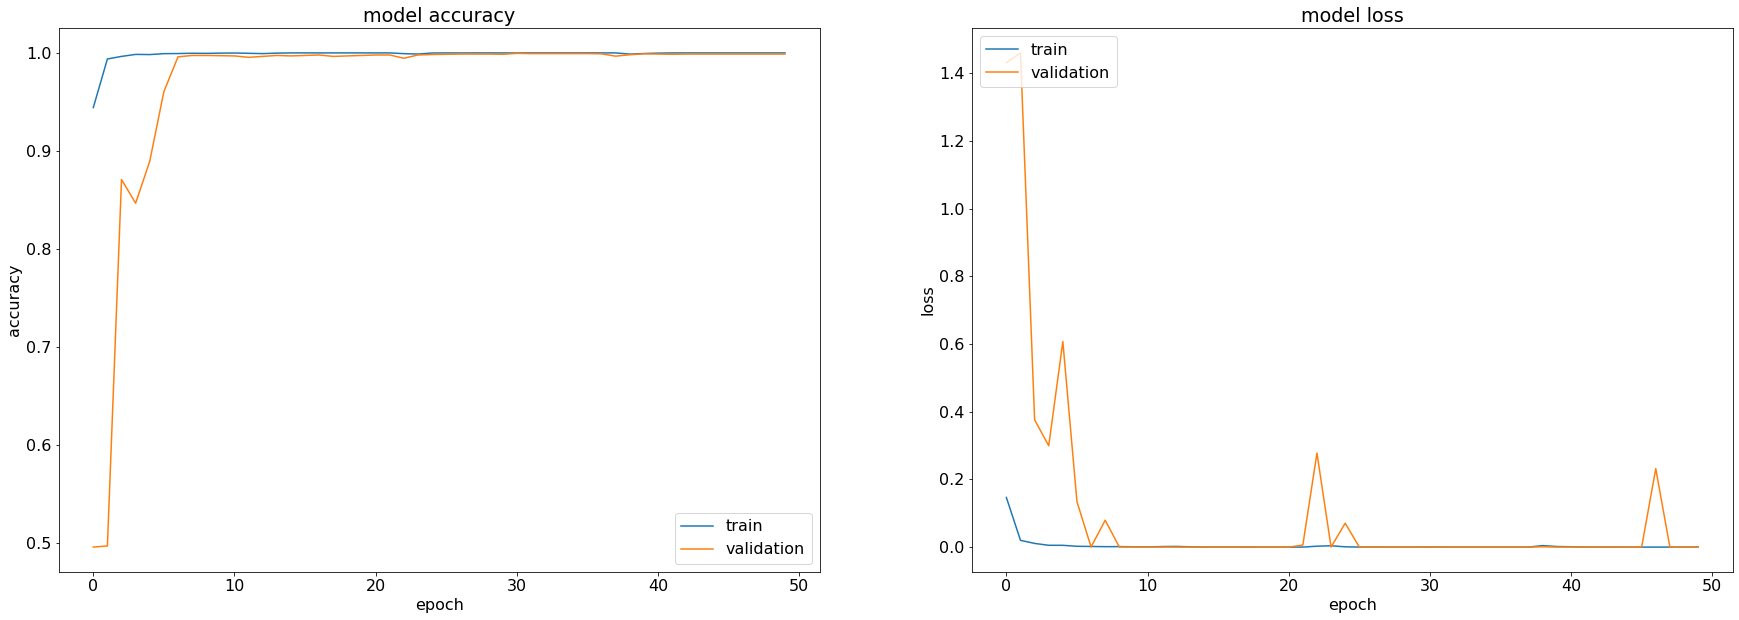

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 0 could not be retrieved. It could be because a worker has died.
  UserWarning)
/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 1 could not be retrieved. It could be because a worker has died.
  UserWarning)
/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 2 could not be retrieved. It could be because a worker has died.
  UserWarning)
/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 10 could not be retrieved. It could be because a worker has died.
  UserWarning)
/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 31 could not be retrieved. It could be because a worker has died.
  UserWarning)


loss: 12.20%
accuracy: 99.68%


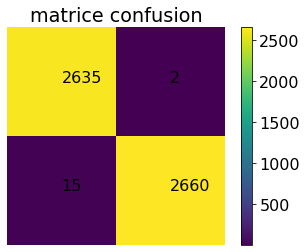

In [ ]:
LED = False 

plot_train(model_01)

# if SAVE[0]:
#     SaveModel(model_01, where=Folder_save)
# #%%
#évaluation
scores = model_01.evaluate_generator(generator=testing_generator)
print("%s: %.2f%%" % (model_01.metrics_names[0], scores[0]*100))
print("%s: %.2f%%" % (model_01.metrics_names[1], scores[1]*100))

Y_pred = model_01.predict_generator(generator=testing_generator)
Y_pred = np.argmax(Y_pred, axis=1)
Y_test = get_labels(partition['test'])[:len(Y_pred)]
Y_test = Y_test.reshape([len(Y_test),])
Y_test = np.array(Y_test, dtype='uint64')


matrix = confusion_matrix(Y_test, Y_pred)

plt.figure()
plt.imshow(matrix)
plt.title("matrice confusion")
for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        plt.text(i,j,str(matrix[j,i]))
plt.colorbar()
plt.axis('off')
plt.xlabel("prediction")
plt.ylabel("reality")
plt.show()

#%%visualisation error

f_neg = np.where(Y_test > Y_pred)
f_pos = np.where(Y_test < Y_pred)
part=np.array(partition['test'])
image_neg_name = part[f_neg]
image_pos_name = part[f_pos]

image_neg = []
image_pos = []
for i in range(len(image_neg_name)):
    image_neg.append(imread(image_neg_name[i]))
for i in range(len(image_pos_name)):    
    image_pos.append(imread(image_pos_name[i]))



['/content/drive/My Drive/Stage/led0/CAT01/9994A323901/infected_1234.tif'
 '/content/drive/My Drive/Stage/led0/CAT01/9994A323929/infected_7141.tif'
 '/content/drive/My Drive/Stage/led0/CAT01/9994A323977/infected_9380.tif'
 '/content/drive/My Drive/Stage/led0/CAT01/9994A323956/infected_3232.tif'
 '/content/drive/My Drive/Stage/led0/CAT01/9994A323986/infected_5033.tif'
 '/content/drive/My Drive/Stage/led0/CAT01/9994A323977/infected_10265.tif'
 '/content/drive/My Drive/Stage/led0/CAT01/9994A323956/infected_3455.tif'
 '/content/drive/My Drive/Stage/led0/CAT01/9994A323956/infected_3164.tif'
 '/content/drive/My Drive/Stage/led0/CAT01/9994A323929/infected_5538.tif'
 '/content/drive/My Drive/Stage/led0/CAT01/9994A323929/infected_10121.tif'
 '/content/drive/My Drive/Stage/led0/CAT01/9994A323986/infected_6197.tif'
 '/content/drive/My Drive/Stage/led0/CAT01/9994A323956/infected_3457.tif'
 '/content/drive/My Drive/Stage/led0/CAT01/9994A323929/infected_9168.tif'
 '/content/drive/My Drive/Stage/led0

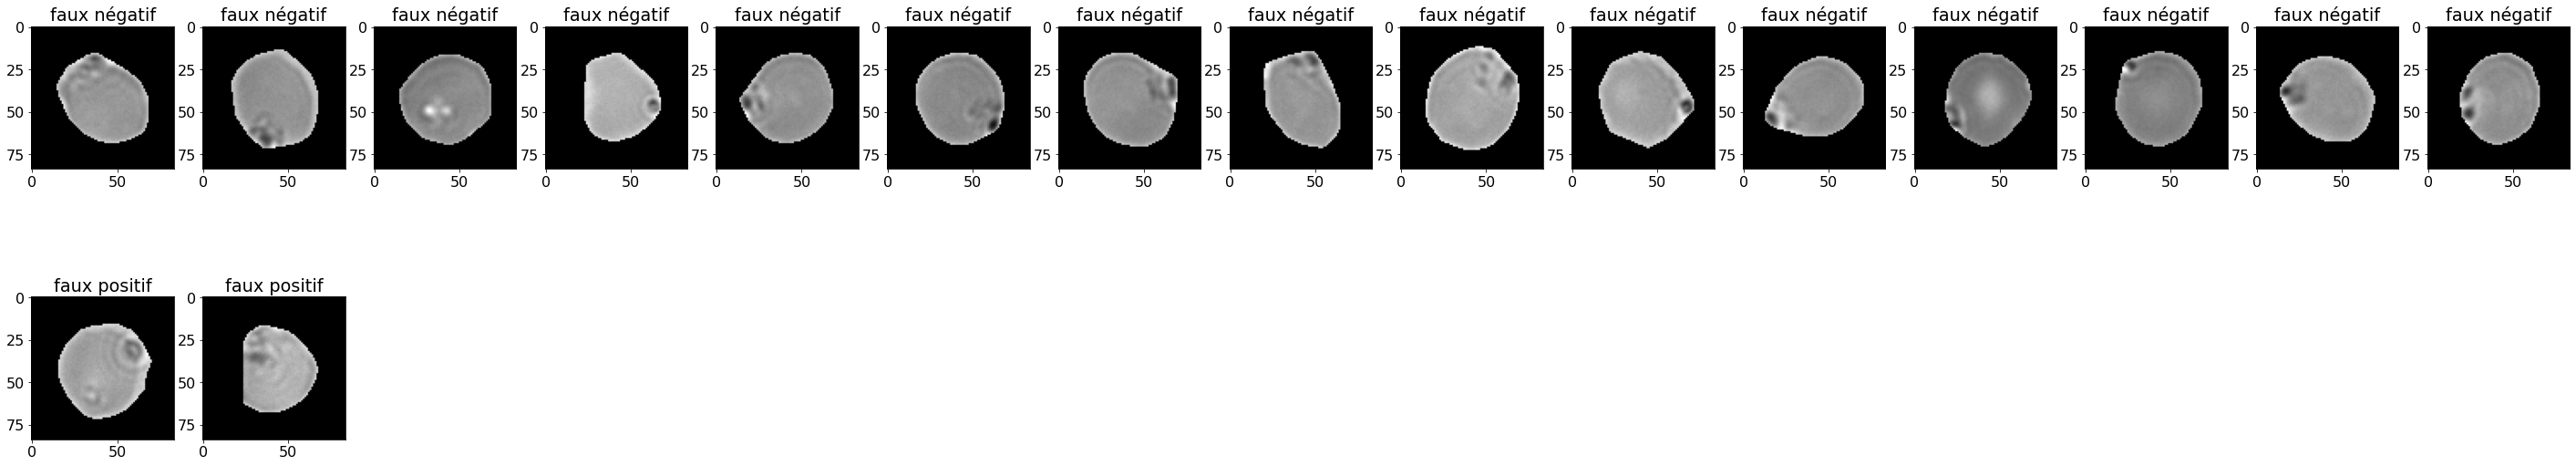

process complet in: 3:47:48.528161


In [ ]:
#%%visualisation error

LED = True
f_neg = np.where(Y_test > Y_pred)
f_pos = np.where(Y_test < Y_pred)
part=np.array(partition['test'])
image_neg_name = part[f_neg]
image_pos_name = part[f_pos]

image_neg = []
image_pos = []
for i in range(len(image_neg_name)):
    image_neg.append(imread(image_neg_name[i]))
for i in range(len(image_pos_name)):    
    image_pos.append(imread(image_pos_name[i]))

# image_neg = []
# image_pos = []
# for i in range(len(image_neg_name)):
#     image_neg.append(imread(image_neg_name[i].replace("inten","phase")))
# for i in range(len(image_pos_name)):    
#     image_pos.append(imread(image_pos_name[i].replace("inten","phase")))


print(image_neg_name)
print(image_pos_name)

plt.figure(figsize=(60,10))
for j in range(min(18,len(image_neg))):
    plt.subplot(2,18,j+1)
    if LED:
        plt.imshow(image_neg[j][0,:,:], cmap='gray')
    else:
        plt.imshow(image_neg[j], cmap='gray')
    plt.title('faux négatif')


for j in range(18,min(36,18+len(image_pos))):
    print(j)
    plt.subplot(2,18,j+1)
    if LED:
        plt.imshow(image_pos[j-18][0,:,:], cmap='gray')
    else:
        plt.imshow(image_pos[j-18], cmap='gray')
    plt.title("faux positif")
plt.show()

if SAVE[2]:
    travel_output=Folder_save+'image/'
    if not os.path.exists(travel_output):
        os.mkdir(travel_output)
    travel_output=travel_output+model_01.name+'/'
    if not os.path.exists(travel_output):
        os.mkdir(travel_output)
    #faux négatif
    travel_output_neg=travel_output+'/faux_neg/'
    if not os.path.exists(travel_output_neg):
        os.mkdir(travel_output_neg)
    for i,image in enumerate(image_neg):
        traveling, name_image = os.path.split(image_neg_name[i])
        traveling, folder = os.path.split(traveling)
        traveling, stat = os.path.split(traveling)
        traveling, champ = os.path.split(traveling)
        traveling, colori = os.path.split(traveling)
        traveling, patient = os.path.split(traveling)
        title=patient+'/'
        if not os.path.exists(travel_output_neg+title):
            os.mkdir(travel_output_neg+title)
        title=title+colori+'/'
        if not os.path.exists(travel_output_neg+title):
            os.mkdir(travel_output_neg+title)
        title=title+champ+'/'
        if not os.path.exists(travel_output_neg+title):
            os.mkdir(travel_output_neg+title)
        title=title+folder+'/'
        if not os.path.exists(travel_output_neg+title):
            os.mkdir(travel_output_neg+title)
        title=title+name_image
        imsave(travel_output_neg+title, image)
        
    #faux positif
    travel_output_pos=travel_output+'/faux_pos/'
    if not os.path.exists(travel_output_pos):
        os.mkdir(travel_output_pos)
    for i,image in enumerate(image_pos):
        traveling, name_image = os.path.split(image_pos_name[i])
        traveling, folder = os.path.split(traveling)
        traveling, stat = os.path.split(traveling)
        traveling, champ = os.path.split(traveling)
        traveling, colori = os.path.split(traveling)
        traveling, patient = os.path.split(traveling)
        title=patient+'/'
        if not os.path.exists(travel_output_pos+title):
            os.mkdir(travel_output_pos+title)
        title=title+color+'/'
        if not os.path.exists(travel_output_pos+title):
            os.mkdir(travel_output_pos+title)
        title=title+colori+'/'
        if not os.path.exists(travel_output_pos+title):
            os.mkdir(travel_output_pos+title)    
        title=title+color+'/'
        if not os.path.exists(travel_output_pos+title):
            os.mkdir(travel_output_pos+title)
        title=title+name_image
        imsave(travel_output_pos+title, image)
# #%%
fin=time.time()
#print(datetime.timedelta(0,fin-debut))
plot_time(debut, fin, title='process complet in:')

LED = False